In [1]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/ICN2/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indic

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
# The current model:
model_dir = Path("results/h_noc_2")
filename = "train_best_model.tar"
config = load_config(model_dir / "config.yaml")

# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)
paths = train_paths + val_paths
basis = get_basis_from_structures_paths(paths, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
model, optimizer, lr_scheduler, loss_fn = init_mace_g2m_model(config, table)

Basis computation.
Number of structures to look on: 629
Looking for unique atoms in each structure...


1it [00:00, 59.60it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [7, 5]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(atomic_energies, dtype=torch.get_default_dtype()),


Using Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
LR Scheduler:  ReduceLROnPlateau
Arguments:  None
Keyword arguments:  {'cooldown': 0, 'eps': 0.0, 'factor': 0.1, 'min_lr': 0.0, 'mode': 'min', 'patience': 20}
Using Loss function <class 'graph2mat.core.data.metrics.block_type_mse'>


In [ ]:
# Load the model
model_path = model_dir / filename
model, checkpoint, optimizer, lr_scheduler = load_model(model, optimizer, model_path, lr_scheduler=None, initial_lr=None, device='cpu')
history = checkpoint["history"]
print(f"Loaded model in epoch {checkpoint["epoch"]} with training loss {checkpoint["train_loss"]} and validation loss {checkpoint["val_loss"]}.")

Loaded model in epoch 24782 with training loss 11333.201171875 and validation loss 35070.49609375.


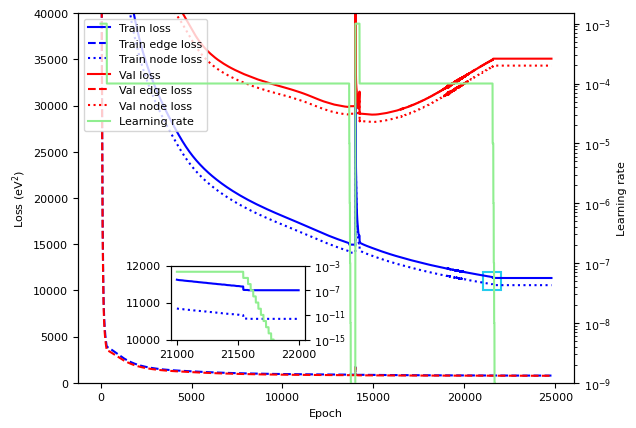

In [151]:
# Plot loss curves
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_loss(
    epochs, train_loss, val_loss, ylim=None, lr=None, lr_ylim=None,
    train_node=None, train_edge=None, val_node=None, val_edge=None,
    zoom_x=None, zoom_y=None, zoom_pos=None, zoom_rect=None,
    zoom2_ylim=None
):
    fig, ax1 = plt.subplots()

    # Left y axis
    label = "Train loss"
    ax1.plot(epochs, train_loss, color="blue", label=label)
    custom_order = [label]
    if train_edge is not None:
        label = "Train edge loss"
        ax1.plot(epochs, train_edge, color="blue", linestyle="dashed", label=label)
        custom_order.append(label)
    if train_node is not None:
        label = "Train node loss"
        ax1.plot(epochs, train_node, color="blue", linestyle="dotted", label=label)
        custom_order.append(label)

    label = "Val loss"
    ax1.plot(epochs, val_loss, color="red", label=label)
    custom_order.append(label)
    if val_edge is not None:
        label = "Val edge loss"
        ax1.plot(epochs, val_edge, color="red", linestyle="dashed", label=label)
        custom_order.append(label)
    if val_node is not None:
        label = "Val node loss"
        ax1.plot(epochs, val_node, color="red", linestyle="dotted", label=label)
        custom_order.append(label)

    # Right y axis
    if lr is not None:
        ax2 = ax1.twinx()
        label="Learning rate"
        ax2.semilogy(epochs, lr, color="lightgreen", label=label)
        custom_order.append(label)
        if lr_ylim is None:
            lr_ylim = ([min(lr), max(lr)])

    # Sub axes
    if zoom_x is not None:
        
        subax = add_subaxes(fig, ax1, zoom_rect, zoom_pos[0], zoom_pos[1])
        sub_epochs = epochs[zoom_x[0]:zoom_x[1]]
        
        zoom_curves = []
        zoom_curves.extend(ax1.get_lines())

        for zoom_curve in zoom_curves:
            subax.plot(sub_epochs, [zoom_curve.get_ydata()[i] for i in sub_epochs], color=zoom_curve.get_color(), linestyle=zoom_curve.get_linestyle())

        if 'ax2' in locals():
            subax2 = subax.twinx()
            subax2_curve = ax2.get_lines()[0]
            subax2.semilogy(sub_epochs, [subax2_curve.get_ydata()[i] for i in sub_epochs], color=subax2_curve.get_color(), linestyle=subax2_curve.get_linestyle())
            subax2.set_ylim(zoom2_ylim)
        
        subax.set_ylim(zoom_y)

        # Draw rectangle on ax1 to indicate zoomed region
        zoom_start = zoom_x[0]
        zoom_end = zoom_x[1]
        zoom_height = zoom_y[1] - zoom_y[0]

        rect = Rectangle(
            (zoom_start, zoom_y[0]),  # (x, y) of bottom-left corner
            zoom_end - zoom_start,    # width
            zoom_height,              # height
            linewidth=1.5,
            edgecolor="#24CCEE",
            facecolor='none',
            linestyle='solid'
        )
        ax1.add_patch(rect)
        

    # Layout
    if ylim == None:
        ylim = [0, max(train_loss)]
        
    ax1.set_ylim(ylim)
    ax2.set_ylim(lr_ylim)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (eV$^2$)")
    ax2.set_ylabel("Learning rate")

    # Legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    handles = handles1 + handles2
    labels = labels1 + labels2

    ax1.legend(handles, labels, loc="upper left")
    
    return fig

def add_subaxes(fig, ax, rect, x, y):
    box = ax.get_position()
    width = box.width
    height = box.height

    width *= rect[2]
    height *= rect[3]

    subax = fig.add_axes([x,y,width,height])

    return subax

train_loss = history["train_loss"]
val_loss = history["val_loss"]
epochs = range(len(train_loss))
lr = history["learning_rate"]
ylim=[0, 40000]
lr_ylim = [10**-9, 1.5*10**-3]
train_node=history["train_edge_loss"] # Recall that there were exchanged.
train_edge=history["train_node_loss"]
val_node=history["val_edge_loss"]
val_edge=history["val_node_loss"]
zoom_rect = [0.2, 0.2, 0.27, 0.2]
zoom_pos = [0.27, 0.2]
fig = plot_loss(epochs, train_loss, val_loss, ylim=ylim, lr=lr, lr_ylim=lr_ylim, 
    train_node=train_node, train_edge=train_edge, val_node=val_node, val_edge=val_edge,
    zoom_x=[21000,22000], zoom_y=[10000,12000], zoom_pos=zoom_pos, zoom_rect=zoom_rect,
    zoom2_ylim=[10**-15, 10**-3]
)
fig.show()

In [5]:
history.keys()

dict_keys(['train_loss', 'val_loss', 'train_edge_loss', 'train_node_loss', 'val_edge_loss', 'val_node_loss', 'learning_rate', 'epoch_times', 'elapsed_time'])